<a href="https://colab.research.google.com/github/justinwickelgren/data-science-class/blob/main/JustWickU6proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
!pip install git+https://github.com/pydata/xarray.git

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-joi67bg6
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-joi67bg6
  Resolved https://github.com/pydata/xarray.git to commit c25215299c02cd36781cf3aa38e8583d1fe14849
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [51]:
import xarray as xr

In [52]:
!pip install bambi

In [53]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import bambi as bmb

# Fabric Acoustics

This project uses a University of Florida data set of sound absoprtion of different fabrics with various properties of the fabrics. I will be trying to predict the acoustic absorption coefficient (portion of sound that is absorbed) at with a 3 cm air gap (acoustic3). This is interesting because understanding what affects sound absorption could allow people to design better fabrics for absorbing sound.

In [54]:
url = "https://users.stat.ufl.edu/~winner/data/fabricsoundabsorb.csv"
fabrics = pd.read_csv(url)
fabrics

,sampleID,thickness,diameter,perforation,weight,stiffness,airPerm,acoustic0,acoustic1,acoustic2,acoustic3
0,1,0.547,0.269,6.14,247,181.90,805.4,0.076,0.330,0.413,0.313
1,2,0.541,0.378,6.08,253,74.40,887.8,0.092,0.339,0.347,0.261
2,3,0.875,0.584,4.97,366,71.41,598.4,0.129,0.455,0.411,0.316
3,4,0.640,0.527,4.87,319,161.50,799.2,0.115,0.433,0.427,0.321
4,5,0.750,0.534,4.51,292,156.20,753.2,0.095,0.362,0.382,0.273
5,6,0.539,0.368,4.39,232,171.50,704.0,0.073,0.371,0.422,0.312
6,7,0.809,0.534,4.13,368,202.90,655.3,0.160,0.479,0.430,0.343
7,8,0.798,0.516,3.78,371,171.36,679.6,0.121,0.444,0.415,0.318
8,9,0.526,0.348,3.67,229,91.10,748.6,0.074,0.361,0.406,0.298
9,10,0.645,0.377,3.46,288,81.30,628.8,0.165,0.520,0.502,0.402


## Variable Selection
I will discuss each potential predictor variable in turn:

Thickness: I expect thickness to have a correlation with sound absorption. Logically, a thicker fabric should absorb more sound than a thinner one.

Diameter: I expect pore diameter to have a correlation with sound absorption because larger pores likely allow more sound to pass through. However, perforation is likely a better measure of this because it takes into account the relative area of pores vs fabric.

Perforation: I expect perforation to be a very strong predictor because large holes in a fabric will presumably allow sound to travel right through them.

Weight: I don't expect weight to be very strongly correlated with sound absorption. Weight is probably a decent proxy for other things that I do expect to be correlated with absorption (e.g. thickness, perforation), but I can just use those as predictors directly.

Stiffness: I expect no correlation between stiffness and sound absorption.

Air permeability: I expect this to be a very strong predictor because sound travels through waves of (usually) air. If a fabric allows air to move through it easily, that will probably carry the sound with it.

Based on this, I will start with a model with perforation and air permeability and try adding different variables to see if they improve it (in an attempt to minimize the number of variables to avoid overfitting).

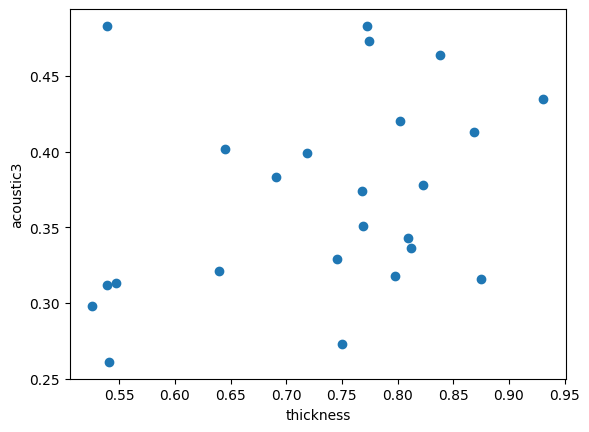

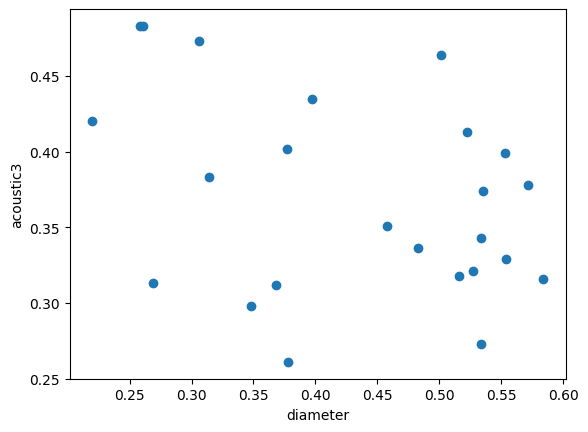

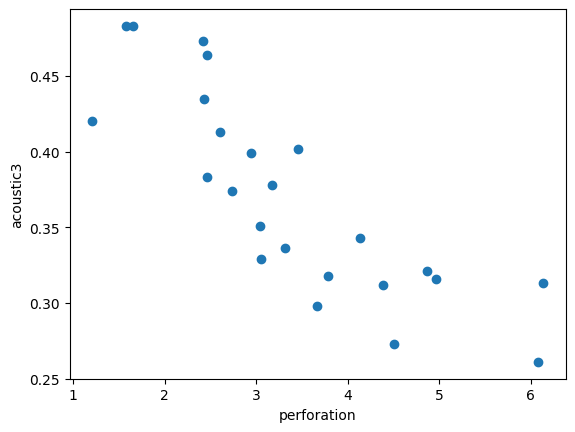

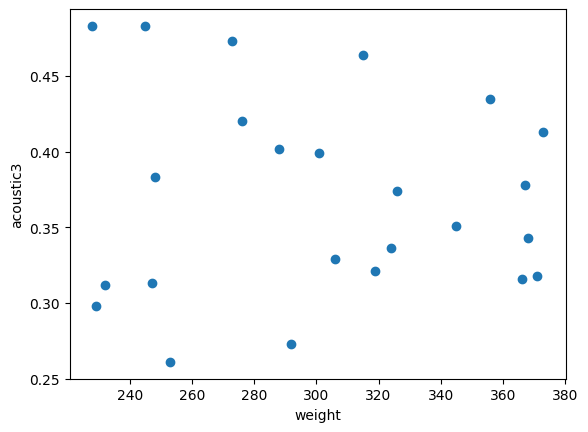

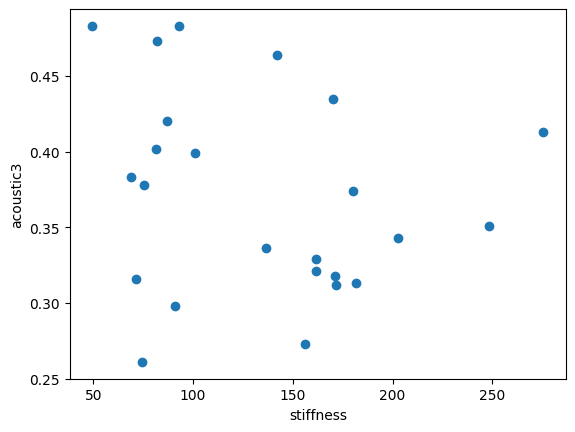

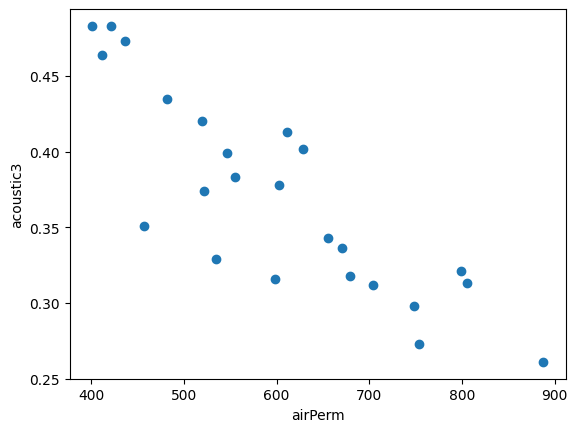

In [55]:
x = ["thickness", "diameter", "perforation", "weight", "stiffness", "airPerm"]
y = "acoustic3"
for a in x:
  plt.scatter(fabrics[a], fabrics[y])
  plt.xlabel(a)
  plt.ylabel(y)
  plt.show()

These scatterplots also show that air permeability and perforation have the greatest correlation with sound absorption, suggesting that my intuition about the variables was correct.

In [56]:
model = bmb.Model("acoustic3 ~ perforation + airPerm + thickness", fabrics)
idata = model.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

In [57]:
model_2 = bmb.Model("acoustic3 ~ perforation + airPerm + diameter", fabrics)
idata_2 = model_2.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

In [58]:
model_3 = bmb.Model("acoustic3 ~ perforation + airPerm + weight", fabrics)
idata_3 = model_2.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

In [59]:
model_4 = bmb.Model("acoustic3 ~ perforation + airPerm + stiffness", fabrics)
idata_4 = model_2.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

In [60]:
model_5 = bmb.Model("acoustic3 ~ perforation + airPerm", fabrics)
idata_5 = model_2.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

In [61]:
compare = az.compare({"w/ thickness":idata, "w/ diameter":idata_2, "w/ weight":idata_3, "w/ stiffness":idata_4, "original":idata_5})
compare

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
w/ diameter,0,45.806254,4.082118,0.000000,1.000000e+00,2.659058,0.000000,False,log
w/ stiffness,1,45.750735,4.047609,0.055519,2.442491e-15,2.649704,0.063877,False,log
w/ weight,2,45.547092,4.324678,0.259163,0.000000e+00,2.707205,0.108316,True,log
original,3,45.448774,4.341843,0.357480,0.000000e+00,2.731040,0.160528,False,log
w/ thickness,4,44.025814,4.112045,1.780440,0.000000e+00,2.736381,1.403184,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

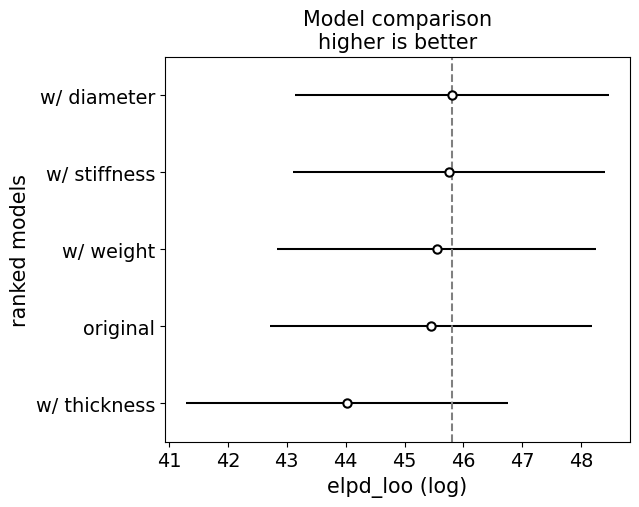

In [62]:
az.plot_compare(compare)

Because the error bars are overlapping for all five models, there isn't one clear winner. However, since we want to avoid overfitting, I'd pick the model with only perforation and air permeability since it is almost the best and have one fewer predictor than the others.

Next, I'll try these two predictors with different likelihoods to see which one works best.

In [63]:
model = bmb.Model("acoustic3 ~ perforation + airPerm", fabrics, family="gaussian")
idata = model.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

In [64]:
model_2 = bmb.Model("acoustic3 ~ perforation + airPerm", fabrics, family="beta")
idata_2 = model_2.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

In [65]:
model_3 = bmb.Model("acoustic3 ~ perforation + airPerm", fabrics, family="gamma")
idata_3 = model_2.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

In [66]:
model_4 = bmb.Model("acoustic3 ~ perforation + airPerm", fabrics, family="wald")
idata_4 = model_2.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

In [67]:
model_5 = bmb.Model("acoustic3 ~ perforation + airPerm", fabrics, family="t")
idata_5 = model_2.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

In [68]:
compare = az.compare({"gaussian":idata, "beta":idata_2, "gamma":idata_3, "wald":idata_4, "t":idata_5})
compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
t,0,45.419462,3.242744,0.000000,1.000000e+00,2.634459,0.000000,False,log
beta,1,45.302254,3.356642,0.117207,0.000000e+00,2.660820,0.053188,False,log
gamma,2,45.237559,3.390510,0.181902,7.062620e-16,2.680113,0.068319,False,log
wald,3,45.152555,3.415397,0.266907,1.505948e-15,2.634415,0.074940,False,log
gaussian,4,44.782490,3.335226,0.636972,6.106227e-15,2.756141,0.319779,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

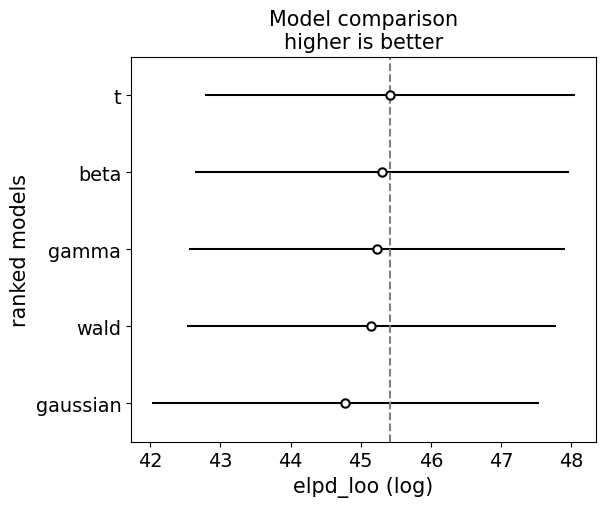

In [69]:
az.plot_compare(compare)

This again suggests that all the models are pretty similar, but the student t distribution is marginally better than the others, so I will select that as the final model. Now I will look in more detail at that model.

In [70]:
model_5

       Formula: acoustic3 ~ perforation + airPerm
        Family: t
          Link: mu = identity
  Observations: 24
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.3699, sigma: 0.8639)
            perforation ~ Normal(mu: 0.0, sigma: 0.1275)
            airPerm ~ Normal(mu: 0.0, sigma: 0.0012)
        
        Auxiliary parameters
            nu ~ Gamma(alpha: 2.0, beta: 0.1)
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.0648)

Bambi selected a gamma and a half Student T for the priors. Because I don't have much knowledge of the context of this data, I will assume that those priors are fine.

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 640x480 with 1 Axes>,
 array([<Axes: xlabel='perforation', ylabel='acoustic3'>], dtype=object))

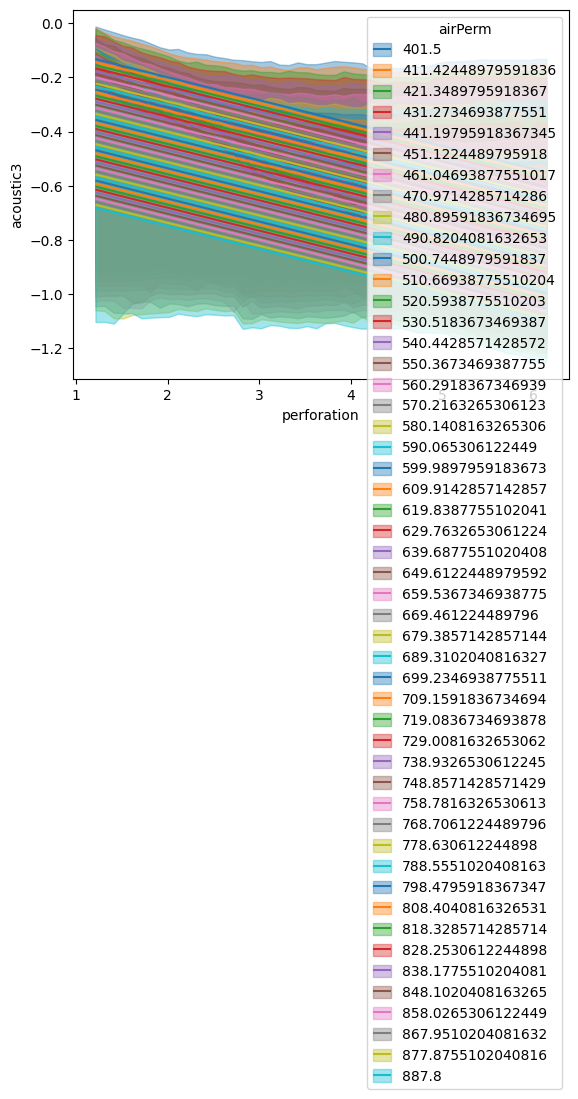

In [71]:
bmb.interpret.plot_predictions(model_5, idata_5, ["perforation", "airPerm"])

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 640x480 with 1 Axes>,
 array([<Axes: xlabel='airPerm', ylabel='acoustic3'>], dtype=object))

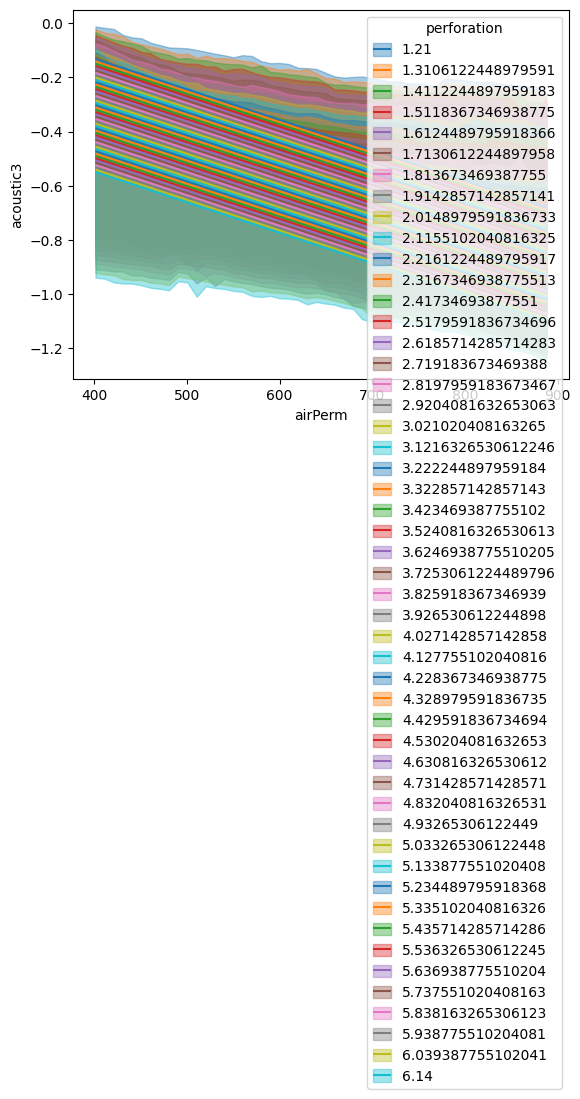

In [72]:
bmb.interpret.plot_predictions(model_5, idata_5, ["airPerm", "perforation"])

In these graphs, we can see that the model found that both air permeability and perforation are negatively correlated with sound absorption. This fits with what I expected based on my intuition about the data. I think this model is a fairly good representation of the data without being overfitted.